In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from collections import Counter, defaultdict, OrderedDict
import matplotlib.pyplot as plt
from numba import cuda 

In [2]:
users = pd.read_csv("data/users2.csv")
users = users.drop('yelping_since', axis = 1)
restaurants = pd.read_csv("data/restaurants2.csv")
reviews = pd.read_csv("data/reviews2.csv")
tips = pd.read_csv("data/tips2.csv")
reviews_sub = reviews[(reviews['business_id'].isin(restaurants['business_id'])) & \
                      (reviews['user_id'].isin(users['user_id']))].copy()

### Prepare data

In [3]:
user, new_user = train_test_split(users, test_size = 0.1, random_state = 48)
user, new_user = user.copy(), new_user.copy()
reviews_new = reviews[(reviews['user_id'].isin(new_user['user_id'])) & (reviews['business_id'].isin(restaurants['business_id']))].copy()
reviews = reviews[(reviews['user_id'].isin(user['user_id'])) & (reviews['business_id'].isin(restaurants['business_id']))].copy()

print("Number of users in the Training:  ", user.shape[0])
print("Number of New users:  ", new_user.shape[0])

Number of users in the Training:   817
Number of New users:   91


In [4]:
user_label_encoder = LabelEncoder(); user['user_id'] = user_label_encoder.fit_transform(user['user_id'])
new_user_label_encoder = LabelEncoder(); new_user['user_id'] = new_user_label_encoder.fit_transform(new_user['user_id'])
restaurant_label_encoder = LabelEncoder(); restaurants['business_id'] = restaurant_label_encoder.fit_transform(restaurants['business_id'])

reviews['user_id'] = user_label_encoder.transform(reviews['user_id'])
reviews_new['user_id'] = new_user_label_encoder.transform(reviews_new['user_id'])
reviews['business_id'] = restaurant_label_encoder.transform(reviews['business_id'])
reviews_new['business_id'] = restaurant_label_encoder.transform(reviews_new['business_id'])

reviews_score = reviews.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()
reviews_new_score = reviews_new.groupby(['user_id', 'business_id'])['stars'].mean().reset_index()
review_train, review_test = train_test_split(reviews_score, test_size = 0.2, random_state = 48)
review_train, review_val = train_test_split(review_train, test_size = 0.2, random_state = 48)

In [5]:
print("Training: {} users, {} items, {} reviews".format(review_train['user_id'].nunique(), review_train['business_id'].nunique(), review_train.shape[0]))
print("Validation: {} users, {} items, {} reviews".format(review_val['user_id'].nunique(), review_val['business_id'].nunique(), review_val.shape[0]))
print("Testing: {} users, {} items, {} reviews".format(review_test['user_id'].nunique(), review_test['business_id'].nunique(), review_test.shape[0]))

Training: 817 users, 1655 items, 34796 reviews
Validation: 817 users, 1540 items, 8700 reviews
Testing: 817 users, 1580 items, 10874 reviews


In [6]:
num_users, num_new_users, num_items = user.shape[0], new_user.shape[0], restaurants.shape[0]
rating_matrix_sparse_train = csr_matrix((review_train['stars'], (review_train['user_id'], review_train['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_val = csr_matrix((review_val['stars'], (review_val['user_id'], review_val['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_test = csr_matrix((review_test['stars'], (review_test['user_id'], review_test['business_id'])), 
                                        shape = (num_users, num_items))
rating_matrix_sparse_new = csr_matrix((reviews_new_score['stars'], (reviews_new_score['user_id'], reviews_new_score['business_id'])), 
                                        shape = (num_new_users, num_items))

rating_matrix_train = rating_matrix_sparse_train.toarray().astype('float32')
rating_matrix_val = rating_matrix_sparse_val.toarray().astype('float32')
rating_matrix_test = rating_matrix_sparse_test.toarray().astype('float32')
rating_matrix_new = rating_matrix_sparse_new.toarray().astype('float32')

rating_matrix_train_mask = np.where(rating_matrix_train==0, 0, 1)
rating_matrix_val_mask = np.where(rating_matrix_val==0, 0, 1)
rating_matrix_test_mask = np.where(rating_matrix_test==0, 0, 1)
rating_matrix_new_mask = np.where(rating_matrix_new==0, 0, 1)

## With Raw Score

In [7]:
import tensorflow as tf
import torch
from torch.autograd import Variable
from torch.optim import Adam

### Matrix Factorization

#### Method 1: Alternating Least Square

In [8]:
p_lambda = 0.2
hidden_dim = 3

P = np.random.normal(0, 0.01, size=(num_users, hidden_dim))
Q = np.random.normal(0, 0.01, size=(num_items, hidden_dim))

In [10]:
for epoch in range(30):
    old_P = P.copy()
    old_Q = Q.copy()
    for u in range(num_users):
        P[u, :] = np.linalg.inv(
            Q.T @ np.diag(rating_matrix_train_mask[u, :]) @ Q + \
            p_lambda * np.identity(hidden_dim)
        ) @ Q.T @ np.diag(rating_matrix_train_mask[u, :]) @ rating_matrix_train[u, :]

    for i in range(num_items):
        Q[i, :] = np.linalg.inv(
            P.T @ np.diag(rating_matrix_train_mask[:, i]) @ P + \
            p_lambda * np.identity(hidden_dim)
        ) @ P.T @ np.diag(rating_matrix_train_mask[:, i]) @ rating_matrix_train[:, i]
    print(np.sum((P-old_P)**2), np.sum((Q-old_Q)**2))

3671.0424847135464 8659.261837990396
4680.6986401109125 5508.232654576992
717.5250261850226 839.564173789189
111.63806403949991 119.49900492564942
45.46327976159775 56.25687211542838
26.505053636113466 35.104978260140015
17.59542336184242 26.505486941682527
11.867005796113524 15.166348009972722
8.000388428521756 11.169272148314075
5.857266550152829 7.56102061058386
4.5570593559300505 5.849388422479077
3.78630929622446 5.188167022758169
3.39993504075803 5.1538834334864
3.1919556898886627 4.524799264533138
2.8972163730839657 3.8844711822155773
2.604598893779265 3.1828193984646007
2.3595709207212545 2.716417156208122
2.1887814446926357 2.8168305829194296
2.0742966284774624 2.9829401959028816
1.929100846903605 2.7411879442516875
1.7142638392021627 2.2644732384741117
1.502117125844558 1.7898549129832086
1.3283905452943365 1.5489372660914005
1.1822090588302994 1.3730953190787323
1.0474066048177866 1.2057209060102685
0.9275615791205083 1.0508841958925075
0.8334751081352629 0.9301519481340033


In [11]:
pred = P@Q.T
sse_train = np.sqrt(np.sum((P@Q.T - rating_matrix_train)**2 * rating_matrix_train_mask) / rating_matrix_sparse_train.nnz)
sse_val = np.sqrt(np.sum((P@Q.T - rating_matrix_val)**2 * rating_matrix_val_mask) / rating_matrix_sparse_val.nnz)
sse_test = np.sqrt(np.sum((P@Q.T - rating_matrix_test)**2 * rating_matrix_test_mask) / rating_matrix_sparse_test.nnz)
print("Training RMSE:  ", sse_train)
print("Validation RMSE:  ", sse_val)
print("Testing RMSE:  ", sse_test)

Training RMSE:   0.6656228295320302
Validation RMSE:   1.0493715353237532
Testing RMSE:   1.0487563675109588


#### Method 2: Stochastic Gradient Descent

In [9]:
p_lambda = 30

P_tensor = tf.Variable(tf.random.normal([num_users, hidden_dim], stddev=0.01))
Q_tensor = tf.Variable(tf.random.normal([num_items, hidden_dim], stddev=0.01))
optimizer = tf.optimizers.Adam(learning_rate=0.005)

num_epochs = 5000
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        penalty_norm = p_lambda * tf.square(tf.norm(P_tensor)) + tf.square(tf.norm(Q_tensor))
        sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_train)**2
        masked_sse = tf.multiply(sse, rating_matrix_train_mask)
        loss = tf.reduce_sum(masked_sse) + penalty_norm
    gradients = tape.gradient(loss, [P_tensor, Q_tensor])
    optimizer.apply_gradients(zip(gradients, [P_tensor, Q_tensor]))
    if epoch % (num_epochs // 20) == 0 or epoch < 10:
        training_rmse = np.sqrt(np.sum(masked_sse) / rating_matrix_sparse_train.nnz)
        validation_sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_val)**2
        validation_sse_masked = tf.multiply(validation_sse, rating_matrix_val_mask)
        validation_rmse = np.sqrt(np.sum(validation_sse_masked) / rating_matrix_sparse_val.nnz)
        print("Epoch i={}: loss:  {}, Training RMSE:  {}, Val RMSE: {}".format(
            epoch, loss, training_rmse, validation_rmse))
#     if epoch > 3000:
#         optimizer = tf.optimizers.Adam(learning_rate=0.005)

Epoch i=0: loss:  549008.5625, Training RMSE:  3.9721144944136064, Val RMSE: 3.9718127267290555
Epoch i=1: loss:  548997.6875, Training RMSE:  3.9720841970111564, Val RMSE: 3.9717901176303045
Epoch i=2: loss:  548985.4375, Training RMSE:  3.9720380721637114, Val RMSE: 3.971730881181243
Epoch i=3: loss:  548964.625, Training RMSE:  3.9719512474684, Val RMSE: 3.9716160232589073
Epoch i=4: loss:  548929.3125, Training RMSE:  3.971802917556443, Val RMSE: 3.971426997871834
Epoch i=5: loss:  548875.3125, Training RMSE:  3.971580186171815, Val RMSE: 3.971152261920502
Epoch i=6: loss:  548799.5, Training RMSE:  3.97126969813045, Val RMSE: 3.9707795855777968
Epoch i=7: loss:  548699.125, Training RMSE:  3.9708603505046063, Val RMSE: 3.9702976324489687
Epoch i=8: loss:  548571.6875, Training RMSE:  3.9703405765245083, Val RMSE: 3.969696861888494
Epoch i=9: loss:  548414.875, Training RMSE:  3.969703545725705, Val RMSE: 3.968968396108785
Epoch i=250: loss:  112258.34375, Training RMSE:  1.0862737

In [10]:
testing_sse = (tf.matmul(P_tensor, tf.transpose(Q_tensor)) - rating_matrix_val)**2
testing_sse_masked = tf.multiply(validation_sse, rating_matrix_test_mask)
print("Testing RMSE:  ", np.sqrt(np.sum(validation_sse_masked) / rating_matrix_sparse_test.nnz))

Testing RMSE:   0.8180381407265215


### AutoEncoder

In [11]:
from AutoRec import AutoRec

In [40]:
user_param_ordered_dict = OrderedDict({
    "train_X": rating_matrix_train,
    'train_y': rating_matrix_train,
    'train_y_mask': rating_matrix_train_mask,
    'val_X': rating_matrix_val, 
    'val_y': rating_matrix_val, 
    'val_y_mask': rating_matrix_val_mask,
    'hidden_dim': 100,
    'p_lambda': 30, 
    'learning_rate': 0.005, 
    'num_epochs': 1500,
    'dropout': 0.95
})

In [41]:
uAuto = AutoRec()
uAuto.train(**user_param_ordered_dict)

Epoch: 0, loss: 551796.625, train_rmse: 3.7964797784128206, val_rmse: 3.7938712487015342
Epoch: 1, loss: 504339.34375, train_rmse: 3.5503248312437092, val_rmse: 3.5909353670519923
Epoch: 2, loss: 439933.6875, train_rmse: 3.214134318113553, val_rmse: 3.357125667033165
Epoch: 3, loss: 369685.53125, train_rmse: 2.823737703582669, val_rmse: 3.096396827246406
Epoch: 4, loss: 287873.9375, train_rmse: 2.4200721949589967, val_rmse: 2.814533906973897
Epoch: 5, loss: 231124.515625, train_rmse: 2.0387875294710027, val_rmse: 2.5237585146423744
Epoch: 6, loss: 183508.65625, train_rmse: 1.7016507416987074, val_rmse: 2.237327820383519
Epoch: 7, loss: 157782.90625, train_rmse: 1.4251453952099824, val_rmse: 1.9706694483633331
Epoch: 8, loss: 139971.765625, train_rmse: 1.218737288481465, val_rmse: 1.7351018785923862
Epoch: 9, loss: 132042.765625, train_rmse: 1.0842315075400017, val_rmse: 1.5397887512083277
Epoch: 75, loss: 116373.4765625, train_rmse: 1.0615887857594828, val_rmse: 1.650055443055792
Epoch

In [42]:
print("Test RMSE:  ", uAuto.test(rating_matrix_test, rating_matrix_test, rating_matrix_test_mask))

Test RMSE:   0.8993689057475919


## With Grouping Information (Cold Start: User)
### Add in user/item covaraites
### Method1: KMeans

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
users.head()

,user_id,review_count,useful,funny,cool,elite,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,1jXmzuIFKxTnEnR0pxO0Hg,299,381,106,121,1,23,3.43,17,8,2,6,0,17,47,30,30,4,1
1,CQUDh80m48xnzUkx-X5NAw,4205,21059,8906,14640,1,575,3.90,679,149,140,66,287,1034,1529,1572,1572,492,180
2,e_YQl5LBR7Gdrp_1vdj1yQ,671,1509,646,870,1,57,3.90,113,14,10,22,18,69,101,129,129,37,7
3,D8TvYz5Cy5-4V-LuD5nXvQ,478,2115,1544,1614,0,61,3.80,276,18,4,4,1,164,281,348,348,76,92
4,Vlab9b73R5qPLIv6tE4DJA,955,3140,2130,1800,1,90,3.57,138,21,12,17,4,54,106,175,175,60,11


In [17]:
## Standardize users
user_reduced = user.copy()
user_scaler = StandardScaler()
compliment_columns = [c for c in user.columns if 'compliment_' in c]
receive_columns = ['useful', 'funny', 'cool']
other_columns = ['review_count', 'fans']
std_columns = compliment_columns + receive_columns + other_columns
user_reduced[std_columns] = user_scaler.fit_transform(user_reduced[std_columns])

In [18]:
## Combine compliments and received compliments columns using PCA

compliment_pca = PCA(n_components = 5)
user_reduced['pca_compliment'] = compliment_pca.fit_transform(user_reduced[compliment_columns])[:,0]
user_reduced = user_reduced.drop(compliment_columns, axis = 1)
print("Compliment PCA:  ", compliment_pca.explained_variance_ratio_)

receive_pca = PCA(n_components = 2)
user_reduced['pca_receive'] = receive_pca.fit_transform(user_reduced[receive_columns])[:,0]
print("Receive PCA:  ",receive_pca.explained_variance_ratio_)
user_reduced = user_reduced.drop(receive_columns, axis = 1)

Compliment PCA:   [0.96585643 0.01509357 0.00881778 0.00522637 0.00251069]
Receive PCA:   [0.99086698 0.00750579]


In [19]:
user_reduced.head()

,user_id,review_count,elite,fans,average_stars,pca_compliment,pca_receive
351,261,0.483180,1,0.042877,3.58,-0.189542,-0.213430
889,791,-0.218976,1,-0.263111,3.95,-0.346564,-0.224788
786,181,0.399010,1,0.037942,3.96,-0.356963,-0.082359
270,592,-0.117086,1,-0.134793,4.04,-0.248215,-0.284173
624,397,-0.358522,1,-0.312464,4.06,-0.405147,-0.361500


In [20]:
# Preprocess new users using the trained standardized and pca
new_user_reduced = new_user.copy()
new_user_reduced[std_columns] = user_scaler.transform(new_user_reduced[std_columns])
new_user_reduced['pca_compliment'] = compliment_pca.transform(new_user_reduced[compliment_columns])[:,0]
new_user_reduced = new_user_reduced.drop(compliment_columns, axis = 1)
new_user_reduced['pca_receive'] = receive_pca.fit_transform(new_user_reduced[receive_columns])[:,0]
new_user_reduced = new_user_reduced.drop(receive_columns, axis = 1)

In [21]:
## Remove some extreme cases for more stable kmeans clustering
remove_extreme = lambda df, col, perc: df.loc[df[col] < np.quantile(df[col], 0.95),]
user_reduced_temp = user_reduced.copy()
user_reduced_temp = remove_extreme(user_reduced_temp, 'pca_compliment', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'pca_receive', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'fans', 0.95)
user_reduced_temp = remove_extreme(user_reduced_temp, 'review_count', 0.95)
print(user_reduced_temp.shape)

(665, 7)


In [22]:
cluster_columns = ['review_count', 'elite', 'fans', 'average_stars', 'pca_compliment', 'pca_receive']
kmeans = KMeans(n_clusters=6, random_state = 48)
print("Labels on extreme free users:  ", Counter(kmeans.fit_predict(user_reduced_temp[cluster_columns])))
print("Labels on all existing users:  ", Counter(kmeans.predict(user_reduced[cluster_columns])))
print("Labels on new users:  ", Counter(kmeans.predict(new_user_reduced[cluster_columns])))

Labels on extreme free users:   Counter({2: 206, 1: 133, 3: 115, 5: 107, 0: 55, 4: 49})
Labels on all existing users:   Counter({2: 206, 0: 162, 3: 155, 1: 134, 5: 107, 4: 53})
Labels on new users:   Counter({3: 21, 2: 20, 0: 20, 5: 11, 1: 11, 4: 8})


In [23]:
user_reduced_temp['kmeans_labels'] = kmeans.predict(user_reduced_temp[cluster_columns])
user_reduced['kmeans_labels'] = kmeans.predict(user_reduced[cluster_columns])
new_user_reduced['kmeans_labels'] = kmeans.predict(new_user_reduced[cluster_columns])

In [24]:
user_reduced.groupby('kmeans_labels').mean().reset_index()

,kmeans_labels,user_id,review_count,elite,fans,average_stars,pca_compliment,pca_receive
0,0,450.722222,0.609196,0.993827,0.930346,3.878395,1.429910,1.235307
1,1,401.813433,-0.344975,1.000000,-0.263921,4.179104,-0.375546,-0.333703
2,2,388.116505,-0.368349,1.000000,-0.286278,3.804466,-0.366792,-0.345144
3,3,390.832258,0.460208,1.000000,-0.074519,3.784774,-0.303010,-0.201971
4,4,430.113208,-0.281101,0.000000,-0.328201,3.731132,-0.397347,-0.360214
5,5,403.261682,-0.308570,1.000000,-0.256377,3.413458,-0.352683,-0.316887


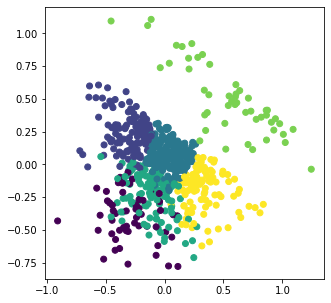

In [25]:
pca_visualize = PCA(n_components = 2)
coords = pca_visualize.fit_transform(user_reduced_temp[cluster_columns])
plt.figure(figsize = (5, 5))
plt.scatter(coords[:, 0], coords[:, 1], c = user_reduced_temp['kmeans_labels'])
plt.show()

In [26]:
def fill_in_group_information(rating_matrix, user_reduced, new_user_reduced, mode = 'uniform', sigma=1, C=1):
    num_new_user, num_item = new_user_reduced.shape[0], rating_matrix.shape[1]
    filled_rating_matrix = np.zeros(shape = (num_new_user, num_item))
    for i in range(num_new_user):
        new_user_group = new_user_reduced.loc[new_user_reduced['user_id'] == i, 'kmeans_labels'].unique()
        obs_user = user_reduced.loc[user_reduced['kmeans_labels'] == new_user_group[0], ]
        obs_ratings = rating_matrix[obs_user['user_id'], :]
        if mode == 'uniform':
            obs_ratings_sum = obs_ratings.sum(0)
            obs_ratings_size = (obs_ratings != 0).sum(0)
            filled_rating_matrix[i] = np.divide(obs_ratings_sum, obs_ratings_size, 
                                                out=np.zeros_like(obs_ratings_sum), where=obs_ratings_size!=0)
        if mode == 'weighted':
            new_user_x = new_user_reduced.loc[new_user_reduced['user_id'] == i].drop(['user_id', 'kmeans_labels'], axis = 1)
            obs_user_x = obs_user.drop(['user_id', 'kmeans_labels'], axis = 1)
            weights = np.exp(-np.sum((obs_user_x.to_numpy() - new_user_x.to_numpy())**2, axis=1) / (2 * 0.1**2))
            weights = weights.reshape(obs_user.shape[0], 1)
            obs_ratings_weighted_sum = (obs_ratings * weights).sum(0)
            obs_ratings_mask = np.abs(np.sign(obs_ratings))
            obs_ratings_weighted_mask = (obs_ratings_mask * weights).sum(0)
            filled_rating_matrix[i] = np.divide(obs_ratings_weighted_sum, obs_ratings_weighted_mask, 
                                    out=np.zeros_like(obs_ratings_weighted_sum), where=obs_ratings_weighted_mask!=0)
    np.random.seed(48)
    random_choice = np.random.choice(np.arange(2), size=filled_rating_matrix.shape, p=[0.9, 0.1])
    filled_rating_matrix = filled_rating_matrix * random_choice
    return filled_rating_matrix.astype('float32')

In [27]:
new_user_filled = fill_in_group_information(rating_matrix_train, user_reduced_temp, new_user_reduced,
                                            mode='weighted', sigma=1)

In [28]:
print("Filled new user RMSE:  ", uAuto.test(new_user_filled, rating_matrix_new, rating_matrix_new_mask))

Filled new user RMSE:   0.9229665516021106


### Method 2: Semi-AutoEncoder

In [29]:
user_reduced

,user_id,review_count,elite,fans,average_stars,pca_compliment,pca_receive,kmeans_labels
351,261,0.483180,1,0.042877,3.58,-0.189542,-0.213430,3
889,791,-0.218976,1,-0.263111,3.95,-0.346564,-0.224788,2
786,181,0.399010,1,0.037942,3.96,-0.356963,-0.082359,3
270,592,-0.117086,1,-0.134793,4.04,-0.248215,-0.284173,3
624,397,-0.358522,1,-0.312464,4.06,-0.405147,-0.361500,1
...,...,...,...,...,...,...,...,...
347,443,-0.430509,1,-0.277917,3.90,-0.396551,-0.389774,2
452,621,1.142143,1,0.052748,3.82,-0.310146,-0.150509,3
337,510,-0.304254,1,-0.021282,4.06,-0.306908,-0.324567,1
563,721,-0.314221,1,-0.396363,4.06,-0.408290,-0.404789,1


In [30]:
user_covariates = user_reduced.sort_values('user_id').drop(['user_id', 'kmeans_labels'], axis = 1).astype('float32')
rating_matrix_train_user = np.concatenate([rating_matrix_train, user_covariates], axis = 1).astype('float32')
rating_matrix_val_user = np.concatenate([rating_matrix_val, user_covariates], axis = 1).astype('float32')
rating_matrix_test_user = np.concatenate([rating_matrix_test, user_covariates], axis = 1).astype('float32')

new_user_covariates = new_user_reduced.sort_values('user_id').drop(['user_id', 'kmeans_labels'], axis = 1).astype('float32')
rating_matrix_new_user = np.concatenate([new_user_filled, new_user_covariates], axis=1).astype('float32')

In [43]:
semi_user_param_ordered_dict = user_param_ordered_dict.copy()
semi_user_param_ordered_dict['train_X'] = rating_matrix_train_user
semi_user_param_ordered_dict['val_X'] = rating_matrix_val_user

In [44]:
semi_uAuto = AutoRec()
semi_uAuto.train(**semi_user_param_ordered_dict)

Epoch: 0, loss: 551952.0625, train_rmse: 3.7976000751659074, val_rmse: 3.795755105998363
Epoch: 1, loss: 504738.53125, train_rmse: 3.546976332577159, val_rmse: 3.589796738674768
Epoch: 2, loss: 441542.03125, train_rmse: 3.206024694655446, val_rmse: 3.3502440563440996
Epoch: 3, loss: 367625.0625, train_rmse: 2.812368037291934, val_rmse: 3.0808090979929057
Epoch: 4, loss: 295531.0, train_rmse: 2.4097078745673324, val_rmse: 2.789583199205099
Epoch: 5, loss: 229802.875, train_rmse: 2.0300752602849403, val_rmse: 2.4882546471245224
Epoch: 6, loss: 181582.375, train_rmse: 1.6956359911639072, val_rmse: 2.1923471543664386
Epoch: 7, loss: 152304.71875, train_rmse: 1.4211420965563004, val_rmse: 1.9171781980753086
Epoch: 8, loss: 137758.484375, train_rmse: 1.2166244589037156, val_rmse: 1.6760242649096975
Epoch: 9, loss: 130535.9453125, train_rmse: 1.0838157142078064, val_rmse: 1.477336800188951
Epoch: 75, loss: 111469.046875, train_rmse: 1.0499732151415373, val_rmse: 1.534404664425187
Epoch: 150, 

In [45]:
print("Test RMSE:  ", semi_uAuto.test(rating_matrix_test_user, rating_matrix_test, rating_matrix_test_mask))
print("New User RMSE:  ", semi_uAuto.test(rating_matrix_new_user, rating_matrix_new, rating_matrix_new_mask))

Test RMSE:   0.8983219084723991
New User RMSE:   0.916898024653502


### Dual AutoEncoder (Cold Start: Users & Items)

In [35]:
from DualAutoRec import DualAutoRec

### Method 1: User & Item Encoder + Fine-tuning

In [46]:
item_param_ordered_dict = OrderedDict({
    "train_X": rating_matrix_train.T,
    'train_y': rating_matrix_train.T,
    'train_y_mask': rating_matrix_train_mask.T,
    'val_X': rating_matrix_val.T, 
    'val_y': rating_matrix_val.T, 
    'val_y_mask': rating_matrix_val_mask.T,
    'hidden_dim': 100,
    'p_lambda': 30, 
    'learning_rate': 0.005, 
    'num_epochs': 1500,
    'dropout': 0.95
})

In [37]:
iAuto = AutoRec()
iAuto.train(**item_param_ordered_dict)

Epoch: 0, loss: 550715.6875, train_rmse: 2.1156883639996766, val_rmse: 2.012990208555764
Epoch: 1, loss: 221267.359375, train_rmse: 2.132890986180977, val_rmse: 1.553418002092205
Epoch: 2, loss: 446413.6875, train_rmse: 1.5453175689885237, val_rmse: 1.360157449208705
Epoch: 3, loss: 389115.15625, train_rmse: 0.9813023373312099, val_rmse: 0.9600172124613093
Epoch: 4, loss: 251487.65625, train_rmse: 1.716870654485937, val_rmse: 1.4451919703548595
Epoch: 5, loss: 268618.3125, train_rmse: 2.2102401360332005, val_rmse: 1.876705163342112
Epoch: 6, loss: 314320.53125, train_rmse: 2.385076766365737, val_rmse: 2.070601252635039
Epoch: 7, loss: 334293.09375, train_rmse: 2.334062127875678, val_rmse: 2.0740251830125196
Epoch: 8, loss: 340134.59375, train_rmse: 2.143377481075684, val_rmse: 1.9489433108060459
Epoch: 9, loss: 328917.96875, train_rmse: 1.868685421582981, val_rmse: 1.7456406087902145
Epoch: 75, loss: 90519.921875, train_rmse: 0.9869566505312565, val_rmse: 0.9732604374630396
Epoch: 150,

In [47]:
dual = DualAutoRec(mode='DUAL-SEP')
dual.uAuto = uAuto
dual.iAuto = iAuto

In [48]:
dual.train(rating_matrix_train, user_param_ordered_dict, item_param_ordered_dict, retrain_user=False, retrain_item=False)

Epoch: 0, loss: 550554.125, train_rmse: 3.8340030430128085
Epoch: 1, loss: 511560.625, train_rmse: 3.0315013256453236
Epoch: 2, loss: 319860.59375, train_rmse: 2.0393443591697844
Epoch: 3, loss: 144827.46875, train_rmse: 1.435596581531381
Epoch: 4, loss: 71871.1953125, train_rmse: 2.303618829027355
Epoch: 5, loss: 184855.046875, train_rmse: 2.148715278145079
Epoch: 6, loss: 160866.890625, train_rmse: 1.4604068018878267
Epoch: 7, loss: 74424.7109375, train_rmse: 1.6981909463392986
Epoch: 8, loss: 100560.7265625, train_rmse: 2.0861853131893096
Epoch: 9, loss: 151655.59375, train_rmse: 1.763074715581972
Epoch: 75, loss: 36162.80078125, train_rmse: 1.0122661232058183
Epoch: 150, loss: 27619.583984375, train_rmse: 0.8845046514592125
Epoch: 225, loss: 26722.08984375, train_rmse: 0.8700264420511782
Epoch: 300, loss: 26355.40234375, train_rmse: 0.8641354663041876
Epoch: 375, loss: 26129.998046875, train_rmse: 0.860554234479702
Epoch: 450, loss: 25975.5078125, train_rmse: 0.8581356378143083
Epo

In [50]:
dual.test(rating_matrix_test, rating_matrix_test.T, rating_matrix_test)

(0.933539450817563, None, None)

### Method 2: Integrate Loss

In [54]:
from DualAutoRec import DualAutoRec

In [55]:
dual = DualAutoRec(mode='DUAL')

In [56]:
dual.train(rating_matrix_train, user_param_ordered_dict, item_param_ordered_dict)

Epoch: 0, loss: 1663231.875, train_rmse: (2.3279959424488688, 3.8030791267915154, 3.7592577175429915)
Epoch: 1, loss: 1254276.0, train_rmse: (10.936450999077568, 3.578231910537221, 3.4980644620214654)
Epoch: 2, loss: 8848067.0, train_rmse: (1.4998117631295664, 3.463434094314214, 3.3555768614091472)
Epoch: 3, loss: 1027127.0625, train_rmse: (6.586514552992094, 3.3791235139876474, 3.249587680654841)
Epoch: 4, loss: 2447423.0, train_rmse: (6.332793667500187, 3.361141199111287, 3.2012772413033614)
Epoch: 5, loss: 2289502.0, train_rmse: (4.929681047541135, 3.391880097152465, 3.194809411547455)
Epoch: 6, loss: 1626859.125, train_rmse: (3.9160706960570617, 3.4395377050385876, 3.2038207440108124)
Epoch: 7, loss: 1323913.5, train_rmse: (3.3602180352721667, 3.478582596293926, 3.211264236900369)
Epoch: 8, loss: 1210329.125, train_rmse: (3.0720268749782402, 3.5027720812015666, 3.211974098733097)
Epoch: 9, loss: 1158999.25, train_rmse: (2.919149970730371, 3.5144126664906183, 3.205083612398739)
Epoc

In [61]:
print("Test RMSE:  ", dual.test(rating_matrix_test, rating_matrix_test.T, rating_matrix_test))

Test RMSE:   (0.929101362334149, None, None)
